In [ ]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from hmpai.training import split_participants, split_participants_custom
from hmpai.pytorch.training import train_and_test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, load_model
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.data import SAT_CLASSES_ACCURACY
from hmpai.pytorch.normalization import *
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.behaviour.sat2 import SAT2_SPLITS
from hmpai.visualization import predict_with_auc, set_seaborn_style, plot_peak_timing
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from pymer4.models import lmer, glmer
from scipy.stats import pearsonr
from prp_visu import *
import matplotlib.gridspec as gridspec
import polars as pl
from scipy.special import expit
from matplotlib.patches import Patch

DATA_PATH = Path(os.getenv("DATA_PATH"))

labels_t1 = ["negative", "t1_1", "t1_2", "t1_3"]
labels_t2 = ["negative", "t2_1", "t2_2", "t2_3"]
labels = ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]
labels_cmb = labels_t1 + labels_t2[1:]
legible_labels = ["E1", "C1", "R1", "E2", "C2", "R2"]
# legible_labels = ["T1 Encoding", "T1 Central", "T1 Response", "T2 Encoding", "T2 Central", "T2 Response"]
# orders = [(0, 1, 2, 3, 4, 5), (0, 1, 3, 2, 4, 5), (0, 3, 1, 2, 4, 5), (0, 1, 3, 4, 2, 5), (0, 3, 1, 4, 2, 5), (0, 3, 4, 1, 2, 5)]
orders = [(0, 1, 2, 3, 4, 5), (0, 1, 3, 2, 4, 5), (0, 3, 1, 2, 4, 5), (0, 1, 3, 4, 2, 5), (0, 3, 1, 4, 2, 5)]

set_global_seed(42)
data_paths = [DATA_PATH / "prp/stage_data_250hz_t2.nc"]
splits = split_participants_custom(data_paths, 0.15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import polars as pl
from scipy.special import expit
from matplotlib.patches import Patch

DATA_PATH = Path(os.getenv("DATA_PATH"))

labels_t1 = ["negative", "t1_1", "t1_2", "t1_3"]
labels_t2 = ["negative", "t2_1", "t2_2", "t2_3"]
labels = ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]
labels_cmb = labels_t1 + labels_t2[1:]
legible_labels = ["E1", "C1", "R1", "E2", "C2", "R2"]
# legible_labels = ["T1 Encoding", "T1 Central", "T1 Response", "T2 Encoding", "T2 Central", "T2 Response"]
# orders = [(0, 1, 2, 3, 4, 5), (0, 1, 3, 2, 4, 5), (0, 3, 1, 2, 4, 5), (0, 1, 3, 4, 2, 5), (0, 3, 1, 4, 2, 5), (0, 3, 4, 1, 2, 5)]
orders = [(0, 1, 2, 3, 4, 5), (0, 1, 3, 2, 4, 5), (0, 3, 1, 2, 4, 5), (0, 1, 3, 4, 2, 5), (0, 3, 1, 4, 2, 5)]

set_global_seed(42)
data_paths = [DATA_PATH / "prp/stage_data_250hz_t2.nc"]
splits = split_participants_custom(data_paths, 0.15)

### Combined tasks

In [3]:
def determine_order(paths: list[Path], labels: list[list[str]]):
    df_t1 = pd.read_csv(paths[0])
    df_t2 = pd.read_csv(paths[1])
    # Combine dataframes on 'epoch' and 'participant'
    df = df_t1.merge(
        df_t2, on=["condition", "epoch", "participant"], suffixes=("_t1", "_t2")
    )
    labels_t1 = labels[0]
    labels_t2 = labels[1]
    pred_cols_t1 = [labels_t1[i] + "_pred" for i in range(1, len(labels_t1))]
    pred_cols_t2 = [labels_t2[i] + "_pred" for i in range(1, len(labels_t2))]

    # Add ISI to task 2 predictions to get absolute time
    df[pred_cols_t2] = df[pred_cols_t2].add(df["interval_t1"] * 250, axis=0)

    peak_order = df[pred_cols_t1 + pred_cols_t2].apply(lambda x: x.argsort(), axis=1)
    for i, col in enumerate(pred_cols_t1 + pred_cols_t2):
        df[f"event_{i}_idx"] = peak_order.iloc[:, i]

    return df

def determine_order_cmb(path):
    df = pd.read_csv(path)
    df_t1 = df[df["task"] == "prp1/t1"].copy()
    df_t2 = df[df["task"] == "prp1/t2"].copy()
    
    df_t1["correct_t1"] = df_t1["correct"]
    df_t2["correct_t2"] = df_t2["correct"]
    df_t1["rt_t1"] = df_t1["rt_samples"]
    df_t2["rt_t2"] = df_t2["rt_samples"]

    id_cols = ["participant", "epoch"]
    meta_cols = ["condition", "interval", "rt_t1", "rt_samples"]
    t1_cols = [col for col in df.columns if col.startswith("t1_")]
    t2_cols = [col for col in df.columns if col.startswith("t2_")]


    df_t1_reduced = df_t1[id_cols + meta_cols + ["correct_t1"] + t1_cols]
    df_t2_reduced = df_t2[id_cols + ["correct_t2", "rt_t2"] + t2_cols]

    df_merged_fixed = pd.merge(df_t1_reduced, df_t2_reduced, on=id_cols, how="inner")

    t1_pred_cols = [col for col in df_merged_fixed.columns if col.startswith("t1_") and col.endswith("_pred")]
    t2_pred_cols = [col for col in df_merged_fixed.columns if col.startswith("t2_") and col.endswith("_pred")]
    df_merged_fixed[t2_pred_cols] = df_merged_fixed[t2_pred_cols].add(df_merged_fixed["interval"] * 250, axis=0)

    peak_order = df_merged_fixed[t1_pred_cols + t2_pred_cols].apply(lambda x: x.argsort(), axis=1)
    for i, col in enumerate(t1_pred_cols + t2_pred_cols):
        df_merged_fixed[f"event_{i}_idx"] = peak_order.iloc[:, i]

    return df_merged_fixed

def remove_rare_orders(df: pd.DataFrame, labels: list[list[str]]):
    # Create a column with order tuples
    order_columns = [
        f"event_{i}_idx" for i in range(len(labels[0]) + len(labels[1]) - 2)
    ]
    df["order"] = df[order_columns].apply(tuple, axis=1)

    # Count number of (order, condition) pairs
    order_condition_counts = df.groupby(["order", "condition"]).size()
    print(order_condition_counts)
    # Calculate 1.5% threshold per condition
    condition_counts = df["condition"].value_counts()
    thresholds = condition_counts * 0.015

    # Keep only (order, condition) pairs above threshold
    valid_combinations = [
        (order, condition)
        for (order, condition), count in order_condition_counts.items()
        if count >= thresholds[condition]
    ]

    # Filter the DataFrame
    df = df[df.set_index(["order", "condition"]).index.isin(valid_combinations)]

    # Re-index orders
    # unique_orders = df["order"].unique()
    order_mapping = {order: idx for idx, order in enumerate(orders)}
    df["order_idx"] = df["order"].map(order_mapping)

    return df

In [19]:
df = determine_order_cmb(Path("files/cmb_peaks.csv"))
df = remove_rare_orders(df, [labels_t1, labels_t2])
df_no_val = df.copy()[~((df["condition"] == "long") & (df["participant"].isin(splits[0])))]

order               condition
(0, 1, 2, 3, 4, 5)  long         10918
                    short          711
(0, 1, 2, 4, 3, 5)  long             1
                    short            3
(0, 1, 3, 2, 4, 5)  long            75
                    short         5397
(0, 1, 3, 4, 2, 5)  long            12
                    short          653
(0, 1, 4, 3, 2, 5)  short            1
(0, 3, 1, 2, 4, 5)  long             1
                    short         2992
(0, 3, 1, 4, 2, 5)  long             3
                    short         1844
(0, 3, 1, 4, 5, 2)  short            4
(0, 3, 4, 1, 2, 5)  short          171
(0, 3, 4, 1, 5, 2)  short            2
(0, 3, 4, 5, 1, 2)  short            3
(1, 0, 2, 3, 4, 5)  long             1
(3, 0, 1, 4, 2, 5)  short            1
(3, 0, 4, 1, 2, 5)  short            1
dtype: int64


/tmp/ipykernel_95154/3516241663.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["order_idx"] = df["order"].map(order_mapping)


### Visualization

In [294]:
def plot_sequence_bargraph(df, ax, labels):
    set_seaborn_style()
    order_counts = (
        df.groupby(["order_idx", "condition"])
          .size()
          .reset_index(name="count")
    )

    # keep plotting order stable
    x_order   = sorted(order_counts["order_idx"].unique())
    hue_order = sorted(order_counts["condition"].unique())

    # draw split bars (temporary gray palette; we'll recolor after)
    g = sns.barplot(
        data=order_counts, x="order_idx", y="count",
        hue="condition", ax=ax,
        order=x_order, hue_order=hue_order,
        palette=["#cccccc"] * len(hue_order),  # placeholder
        errorbar=None
    )

    # recolor bars by sequence (A,B,C,...)
    seq_palette = sns.color_palette()[5:10]  # pick your palette
    for patch, (seq, _cond) in zip(g.patches, order_counts[["order_idx", "condition"]].values):
        patch.set_facecolor(seq_palette[x_order.index(seq)])
    
    # add hatches by condition
    hatch_map = {hue_order[0]: "//", hue_order[1]: ""}  # e.g., long = hatched
    for patch, cond in zip(g.patches, order_counts["condition"].values):
        patch.set_hatch(hatch_map[cond])

    # condition legend (based on hatches)
    ax.legend_.remove()
    handles = [Patch(facecolor="0.85", edgecolor="black", hatch=hatch_map[c]) for c in hue_order]
    ax.legend(handles, hue_order, title="Condition")

    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlabel("Sequence")
    ax.set_ylabel("Trials")
    ax.set_ylim(0, 6000)   
                                                                                                                                                                                                                         
def plot_rt_bargraph(df, ax, labels):
    df = get_rt_regression_df(df)
    # print(df)
    sns.barplot(data=df, x="sequence", y="mean", errorbar=None, ax=ax, hue="sequence", palette=sns.color_palette()[5:10])
    ax.errorbar(
        x=np.arange(len(df)),
        y=df["mean"],
        yerr=df["error"],
        fmt="none",
        ecolor="black",
        capsize=3
    )
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlabel("Sequence")
    ax.set_ylabel("Task 1 RT (in s)")
    ax.set_ylim(0, 1.0)

def get_rt_regression_df(df, task: str = "t1"):
    df = df.copy()
    df = df[df["condition"] == "short"]
    df[f"rt_{task}"] = df[f"rt_{task}"] / 250
    df = df[["participant", "order_idx", f"rt_{task}"]]
    df = df.dropna()
    df["participant"] = df["participant"].astype("category")
    df["order_idx"] = df["order_idx"].astype(str).astype("category")
    df = pl.from_dataframe(df)

    model = lmer(
        f"rt_{task} ~ order_idx + (1|participant)", data=df
    )
    model.set_factors({"order_idx": ["0", "1", "2", "3", "4", "5"]})
    model.fit(verbose=False)
    result = get_rt_means_and_errors(model)
    return result

def get_rt_means_and_errors(model):
    df = model.result_fit.to_pandas()
    b0   = df.loc[df.term == "(Intercept)", "estimate"].iat[0]
    se0  = df.loc[df.term == "(Intercept)", "std_error"].iat[0]
    mask = df.term.str.startswith("order_idx")
    tmp  = df.loc[mask, ["term", "estimate", "std_error"]].copy()
    tmp["mean"]  = b0 + tmp["estimate"]
    tmp["se"]    = np.sqrt(se0**2 + tmp["std_error"]**2)   # approx: no covariance term
    tmp["error"] = 1.96 * tmp["se"]
    row0 = pd.DataFrame({
        "term":  ["order_idx0"],
        "mean":  [b0],
        "error": [1.96 * se0],
    })
    out = pd.concat([row0, tmp[["term", "mean", "error"]]], ignore_index=True)
    out.columns = ["sequence", "mean", "error"]
    return out

def plot_performance_bargraph(df, ax, labels):
    df = get_performance_regression_df(df)
    sns.barplot(data=df, x="sequence", y="proba", errorbar=None, ax=ax, hue="sequence", legend=False, palette=sns.color_palette()[5:10])
    ax.errorbar(
        x=np.arange(len(df)),
        y=df["proba"],
        yerr=df["error"],
        fmt="none",
        ecolor="black",
        capsize=3
    )
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlabel("Sequence")
    ax.set_ylabel("Task 1 Accuracy")
    ax.set_ylim(0.6, 1.0)
    

def get_performance_regression_df(df, task="t1"):
    df = df.copy()
    df = df[df["condition"] == "short"]
    df = df[["participant", "order_idx", f"correct_{task}"]]
    df = df.dropna()
    df["participant"] = df["participant"].astype("category")
    df["order_idx"] = df["order_idx"].astype(str).astype("category")
    df = pl.from_dataframe(df)
    model = glmer(
        f"correct_{task} ~ order_idx + (1|participant)", data=df, family="binomial"
    )
    model.set_factors({"order_idx": ["0", "1", "2", "3", "4", "5"]})
    model.fit(verbose=True)
    # print(model.summary())
    result = get_performance_means_and_errors(model)
    return result

def get_performance_means_and_errors(model):
    df = model.result_fit.to_pandas()
    intercept = df.loc[df.term == "(Intercept)", "estimate"].iat[0]
    intercept_low = df.loc[df.term == "(Intercept)", "conf_low"].iat[0]
    intercept_high = df.loc[df.term == "(Intercept)", "conf_high"].iat[0]

    probs = []
    probs.append({"sequence": 0, "proba": expit(intercept), "error": (expit(intercept_high) - expit(intercept_low)) / 2})

    for _, row in df.iterrows():
        if not row['term'].startswith('order_idx'):
            continue
        order_idx = row['term'].split("x")[-1]
        proba = expit(intercept + row["estimate"])
        err = (expit(intercept_high + row["conf_high"]) - expit(intercept_low + row["conf_low"])) / 2
        probs.append({"sequence": order_idx, "proba": proba, "error": err})
    return pd.DataFrame(probs)


In [321]:
def plot_all(df):
    sequence_labels = ["A","B","C","D","E"]

    fig = plt.figure(figsize=(7.09, 4.2), dpi=300, constrained_layout=True)
    gs  = gridspec.GridSpec(
        2, 9, figure=fig,
        width_ratios=[1,1,1, 1,1,1, 1,1,1], height_ratios=[1,1]
    )

    ax_a = fig.add_subplot(gs[0, 0:3])
    plot_sequence_bargraph(df, ax_a, sequence_labels)

    ax_b = fig.add_subplot(gs[0, 3:6])
    plot_rt_bargraph(df, ax_b, sequence_labels)

    ax_c = fig.add_subplot(gs[0, 6:9])
    plot_performance_bargraph(df, ax_c, sequence_labels)

    ax_d = fig.add_subplot(gs[1, 0:8])
    plot_sequences_per_participant(df, sequence_labels, ax_d)
    
    handles, _ = ax_d.get_legend_handles_labels()
    ax_d.legend().remove()
    fig.legend(handles[::-1], sequence_labels, title="Sequence",
               loc="center left", bbox_to_anchor=(0.885, 0.3))
    
    fig.text(0.005, 0.98, "a)", fontweight="bold")
    fig.text(0.35, 0.98, "b)", fontweight="bold")
    fig.text(0.69, 0.98, "c)", fontweight="bold")
    fig.text(0.005, 0.48, "d)", fontweight="bold")
    plt.savefig("../img/sequences_result.svg", transparent=True, bbox_inches="tight")
    plt.show()

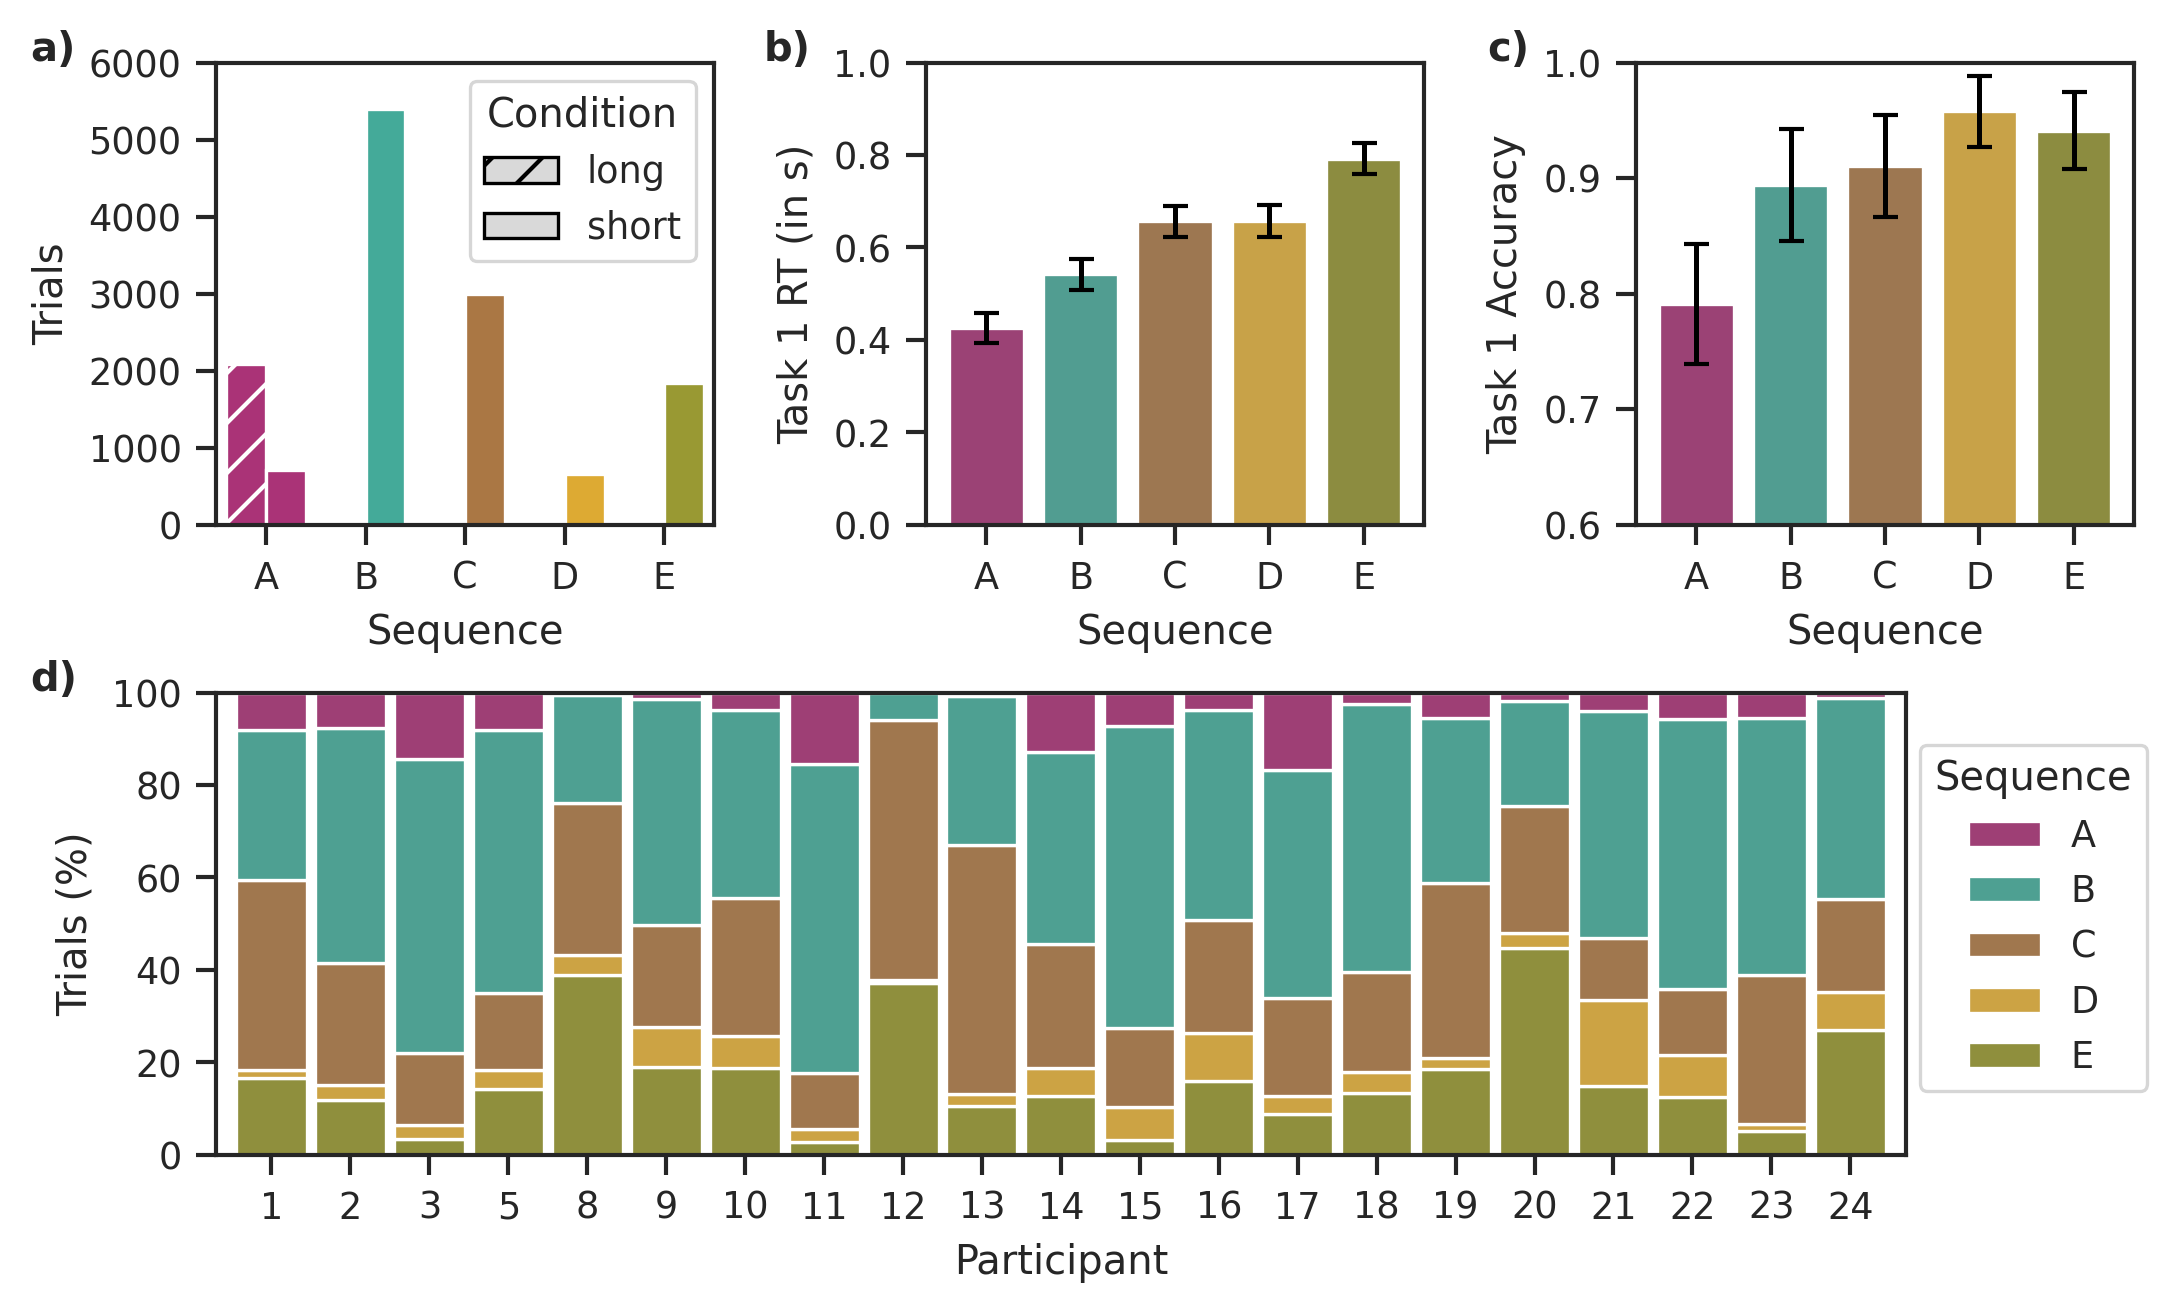

In [322]:
plot_all(df_no_val)

### Replacement of RT graph

In [ ]:
def rt_order_regression(df, task: str = "t1"):
    df = df.copy()
    df = df[["participant", "condition", f"rt_{task}"]]
    df = df.dropna()
    df["participant"] = df["participant"].astype("category")
    df["condition"] = df["condition"].astype("category")

    formula = f"rt_{task} ~ condition + (1|participant)"
    model = lmer(formula, data=df)

    model.fit(verbose=False)

    print(model.summary())
    return model

df_no_val["rt_t1"] = df_no_val["rt_samples_t1"] / 250 * 1000
df_no_val["rt_t2"] = df_no_val["rt_samples_t2"] / 250 * 1000

model_rt_order_t1 = rt_order_regression(df_no_val, task="t1")
model_rt_order_t2 = rt_order_regression(df_no_val, task="t2")

/opt/conda/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: rt_t1~condition+(1|participant)

Family: gaussian	 Inference: parametric

Number of observations: 13760	 Groups: {'participant': 21.0}

Log-likelihood: -89501.870 	 AIC: 179011.739

Random effects:

                    Name        Var      Std
participant  (Intercept)  10228.274  101.135
Residual                  25946.796  161.080

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: rt_t1~condition+(1|participant)

Family: gaussian	 Inference: parametric

Number of observations: 13760	 Groups: {'participant': 21.0}

Log-likelihood: -89501.870 	 AIC: 179011.739

Random effects:

                    Name        Var      Std
participant  (Intercept)  10228.274  101.135
Residual                  25946.796  161.080

No random effect correlations specified

Fixed effects:

                Estimate   2.5_ci  97.5_ci      SE         DF  T-stat  P-val  \
(Intercept)      624.231  580.01

/opt/conda/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
